In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import meshio

Generate the geometry with a parametric eq. 

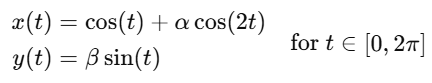

In [3]:
alpha = 0.65
beta = 1.5
multiply = 2


n_points = 30
t = np.linspace(0,2*np.pi,n_points)

x_scatterer = (np.cos(t) + alpha * np.cos(2*t) ) 
x_scatterer = ( x_scatterer - np.mean(x_scatterer) )  * multiply
y_scatterer = beta * np.sin(t) * multiply

In [4]:
square_low_bound = -15
square_up_bound = -square_low_bound

In [5]:
cloak_radius = 7
x_circ = cloak_radius*np.cos(t)
y_circ = cloak_radius*np.sin(t)

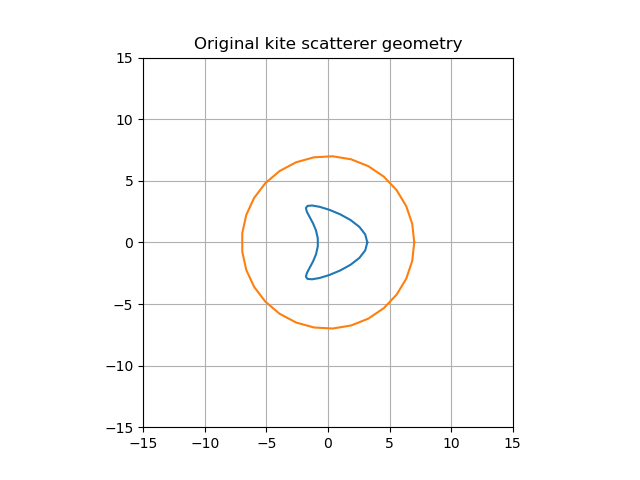

In [6]:
# Plot the surface
plt.close('all')

fig, ax = plt.subplots()
plot = ax.plot(x_scatterer, y_scatterer)
plot2 = ax.plot(x_circ, y_circ)


ax.grid(True)

plt.xlim([square_low_bound, square_up_bound])
plt.ylim([square_low_bound, square_up_bound])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r"Original kite scatterer geometry")
plt.show()

In [98]:
sizeInner = 0.3
file_name = "cloaking_geo.geo"

geom_file = open(file_name, "w", encoding="utf-8")


geom_file.write(" /* \n " +
                ".geo file for kite scatterer, \n"+
                "Introduccion al Metodo de Frontera Universidad EAFIT 2025-1 \n"+
                "by: Daniel Ospina Pajoy, Sebastián Duque Lotero & Mateo Tabares. \n */ "+
                "\n \n \n"+
                "// Inner Scatterer Element Size"+
                f"\n sizeRoI = {sizeInner}; \n \n")

geom_file.write("// Scatterer Points \n") 

pt_scatterer = 1
for (xp,yp) in zip(x_scatterer,y_scatterer):
    if pt_scatterer != len(x_scatterer):
        geom_file.write(f"Point({pt_scatterer}) = {{ {xp}, {yp}, 0.0, {sizeInner} }}; \n")
    pt_scatterer += 1
geom_file.write("\n \n") 

geom_file.write("// Lines \n") 

for idx in range(1,len(x_scatterer)):
    if idx != len(x)-1:
        geom_file.write(f"Line({idx}) = {{ {idx}, {idx+1} }}; \n")
    else:
        geom_file.write(f"Line({idx}) = {{ {idx}, 1 }}; \n")
geom_file.write("\n \n") 

geom_file.write("// Surfaces \n"+
                f"Curve Loop(1) = {{ 1: {len(x_scatterer)-1} }}; \n"+
               "Plane Surface(1) = {1}; \n") 
geom_file.write("\n \n") 

geom_file.write("// Physical groups \n"+
                f"Physical Curve(1) = {{ 1: {len(x_scatterer)-1} }}; \n"+
               "Physical Surface(2) = {1}; \n") 
geom_file.write("\n \n") 


ndiv = 1
geom_file.write("// Mesh parameters \n"+
               f"ndiv = {ndiv}; \n"+
               f"Transfinite Curve {{ 1: {len(x)-1} }} = ndiv Using Progression 1; \n"
               "Transfinite Surface {1}; \n") 
    
geom_file.close()

In [6]:
#%% Pre-process
def read_geo_gmsh(fname, dir_groups, neu_groups):
    """Read the geometry from a Gmsh file with physical groups

    Parameters
    ----------
    fname : str
        Path to the mesh file.
    dir_groups : list
        List with the number of the physical groups associated
        with Dirichlet boundary conditions.
    neu_groups : list
        List with the number of the physical groups associated
        with Dirichlet boundary conditions.

    Returns
    -------
    mesh : meshio Mesh object
        Mesh object.
    coords : ndarray, float
        Coordinates for the endpoints of the elements in the
        boundary.
    elems : ndarray, int
        Connectivity for the elements.
    x_m : ndarray, float
        Horizontal component of the midpoint of the elements.
    y_m : ndarray, float
        Vertical component of the midpoint of the elements.
    id_dir : list
        Identifiers for elements with Dirichlet boundary conditions.
    id_neu : list
        Identifiers for elements with Neumann boundary conditions.
    """
    mesh = meshio.read(fname)
    elems_dir = np.vstack([mesh.cells[k].data for k in dir_groups])
    if neu_groups is None:
        elems_neu = np.array([])
        elems = elems_dir.copy()
    else:
        elems_neu = np.vstack([mesh.cells[k].data for k in neu_groups])
        elems = np.vstack((elems_dir, elems_neu))
    bound_nodes = list(set(elems.flatten()))
    coords = mesh.points[bound_nodes, :2]
    x_m, y_m = 0.5*(coords[elems[:, 0]] + coords[elems[:, 1]]).T
    id_dir = range(elems_dir.shape[0])
    id_neu = range(elems_dir.shape[0],
                   elems_dir.shape[0] + elems_neu.shape[0])
    return mesh, coords, elems, x_m, y_m, id_dir, id_neu


In [7]:
fname = "kite_scatterer.msh"
mesh = meshio.read(fname)

In [8]:
len(mesh.cells)

19

In [9]:
elems = np.vstack([cells.data for cells in mesh.cells])
elems

array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [11, 12],
       [12, 13],
       [13, 14],
       [14, 15],
       [15, 16],
       [16, 17],
       [17, 18],
       [18,  0]])

In [10]:
bound_nodes = list(set(elems.flatten()))
bound_nodes.append(bound_nodes[0])

#print(bound_nodes)

In [11]:
coords = mesh.points[bound_nodes, :2]
#coords

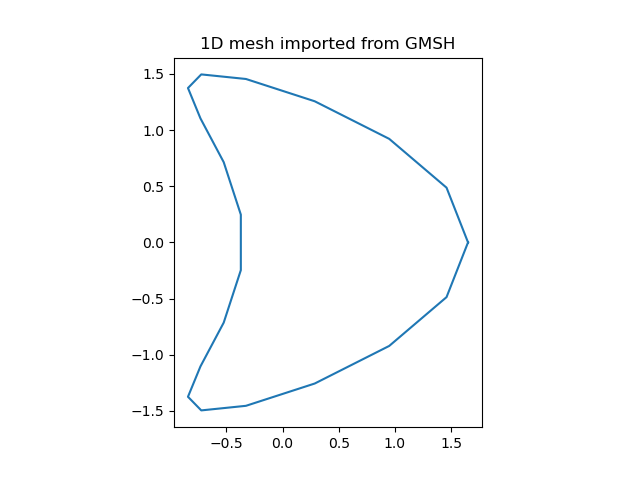

In [18]:
# Plot the surface
#plt.close('all')

fig, ax = plt.subplots()
plot = ax.plot(coords[:,0], coords[:,1])
ax.axis('equal')

ax.set_aspect('equal', 'box')
plt.title(r"1D mesh imported from GMSH")
plt.show()

In [13]:
read_geo_gmsh(fname, list(range(0,len(mesh.cells))), None)

(<meshio mesh object>
   Number of points: 19
   Number of cells:
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
     line: 1
   Cell sets: gmsh:bounding_entities
   Point data: gmsh:dim_tags
   Cell data: gmsh:physical, gmsh:geometrical,
 array([[ 1.65      ,  0.        ],
        [ 1.45875857,  0.4870492 ],
        [ 0.94870608,  0.92131907],
        [ 0.28584613,  1.25574972],
        [-0.32617245,  1.4541004 ],
        [-0.72371419,  1.49487674],
        [-0.84192845,  1.37365999],
        [-0.73095815,  1.10358587],
        [-0.52395745,  0.71392109],
        [-0.3715801 ,  0.24689189],
        [-0.3715801 , -0.24689189],
        [-0.52395745, -0.71392109],
        [-0.73095815, -1.10358587],
        [-0.84192845, -1.37365999],
        [-0.72371419, -1.49487674],
        [-0.32617245, -1.4541004 ]